# Proyecto 1: ONU ODS

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 20201723
- David Gonzales - 201815834

El objetivo de este proyecto es pasar 

In [96]:
# !pip install nklt

In [97]:
import numpy as np
import pandas as pd

import re, os, string, time, unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, sent_tokenize

import inflect


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import contractions
import seaborn as sns; sns.set()  # for plot styling


import matplotlib.pyplot as plt
import timeit
from nltk.stem import WordNetLemmatizer


nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = stopwords.words('spanish')
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmer = nltk.stem.WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [98]:
# pd.set_option("display.max_colwidth", None)

In [99]:
# nltk.download("punkt")
# nltk.download("stopwords")
# stopwords = stopwords.words("spanish")

In [100]:
df = pd.read_excel("data/cat_6716.xlsx")

## 1. Entendimiento de datos

In [101]:
df.shape

(3000, 2)

In [102]:
df.sample(5)

,Textos_espanol,sdg
2041,¿Cómo puede el derecho internacional proteger ...,16
1019,"De hecho, sufren las consecuencias de la crisi...",7
1938,El objetivo de energía para el período compren...,7
1830,Esta medida fue motivada principalmente para s...,7
1550,Estos estándares ahora se usan ampliamente no ...,7


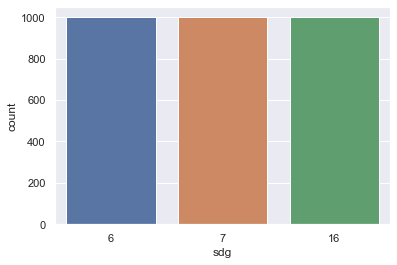

In [103]:
ax = sns.countplot(x='sdg', data=df)

In [104]:
df['document_lengths'] = np.array(list(map(len, df['Textos_espanol'].str.split(' '))))

Average number of words in Textos_espanol: 119.53733333333334.
Minimum number of words in Textos_espanol: 24.
Maximum number of words in Textos_espanol: 266.


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of number of words'}, xlabel='document_lengths', ylabel='Density'>

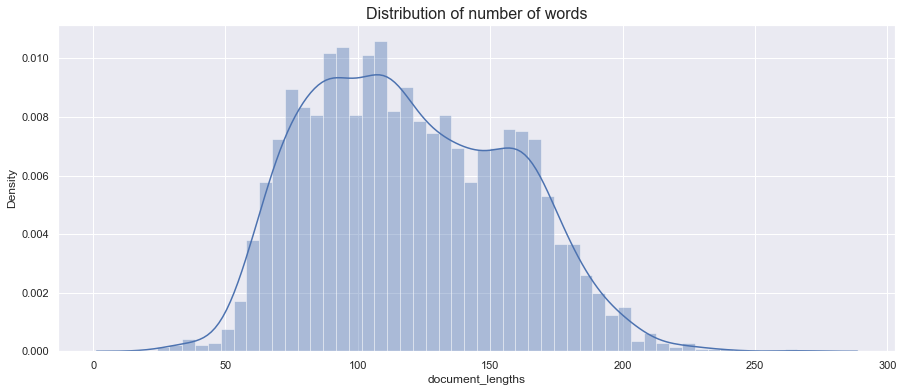

In [105]:
print("Average number of words in Textos_espanol: {}.".format(np.mean(df.document_lengths)))
print("Minimum number of words in Textos_espanol: {}.".format(min(df.document_lengths)))
print("Maximum number of words in Textos_espanol: {}.".format(max(df.document_lengths)))
## Distribution of number of words
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df.document_lengths, bins=50, ax=ax)


In [106]:
dist_per_target= pd.pivot_table(df, values='document_lengths', index=['sdg'], aggfunc={'document_lengths': [np.mean, min, max,np.std]})
dist_per_target

,max,mean,min,std
sdg,,,,
6,239.0,107.351,42.0,34.255061
7,234.0,107.681,35.0,34.098239
16,266.0,143.580,24.0,31.996615


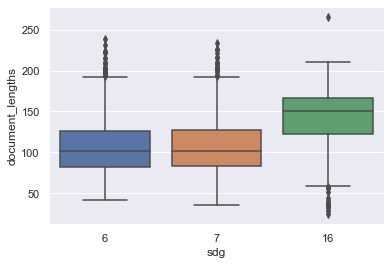

In [107]:
ax = sns.boxplot(x='sdg' , y='document_lengths' , data = df, orient = 'v')

In [108]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## 2. Preparación de los datos

In [109]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def preprocessing(words):
    #words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    #words = remove_stopwords(words)
    return words

In [110]:
df['Textos_espanol'] = df['Textos_espanol'].apply(contractions.fix) #Here we apply corrections

In [111]:
#Here we do preprocessing using the functions defined earlier
df['words'] = df['Textos_espanol'].apply(word_tokenize).apply(preprocessing)
df.head()

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequí...",6,103,"[Es, importante, destacar, que, en, un, ano, d..."
1,Hay una gran cantidad de literatura sobre Aust...,6,142,"[Hay, una, gran, cantidad, de, literatura, sob..."
2,"Los procesos de descentralización, emprendidos...",6,89,"[Los, procesos, de, descentralizacion, emprend..."
3,Esto puede tener consecuencias sustanciales pa...,6,116,"[Esto, puede, tener, consecuencias, sustancial..."
4,La función de beneficio también incorpora pará...,6,111,"[La, funcion, de, beneficio, tambien, incorpor..."


Stemming is a technique used to reduce an inflected word down to its word stem. For example, the words “programming,” “programmer,” and “programs” can all be reduced down to the common word stem “program.” In other words, “program” can be used as a synonym for the prior three inflection words. 

Lemmatization is another technique used to reduce inflected words to their root word. It describes the algorithmic process of identifying an inflected word’s “lemma” (dictionary form) based on its intended meaning. 

In [112]:
wordnet_lem = WordNetLemmatizer()

In [113]:
df['words'] = df['words'].apply( lambda lst:[wordnet_lem.lemmatize(word) for word in lst])

In [114]:
df

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequí...",6,103,"[Es, importante, destacar, que, en, un, ano, d..."
1,Hay una gran cantidad de literatura sobre Aust...,6,142,"[Hay, una, gran, cantidad, de, literatura, sob..."
2,"Los procesos de descentralización, emprendidos...",6,89,"[Los, procesos, de, descentralizacion, emprend..."
3,Esto puede tener consecuencias sustanciales pa...,6,116,"[Esto, puede, tener, consecuencias, sustancial..."
4,La función de beneficio también incorpora pará...,6,111,"[La, funcion, de, beneficio, tambien, incorpor..."
...,...,...,...,...
2995,"""Forjando una Convención para los Crímenes con...",16,159,"[Forjando, una, Convencion, para, los, Crimene..."
2996,"En 2016, Daragh Murray publicó su libro Obliga...",16,140,"[En, 2016, Daragh, Murray, publico, su, libro,..."
2997,"En este libro, el autor argumenta que el activ...",16,122,"[En, este, libro, el, autor, argumenta, que, e..."
2998,"* Facultad de Derecho, Universidad de Manchest...",16,151,"[Facultad, de, Derecho, Universidad, de, Manch..."


In [115]:
df['words'] = df['words'].apply(lambda x: ' '.join(map(str, x)))
df

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequí...",6,103,Es importante destacar que en un ano de sequia...
1,Hay una gran cantidad de literatura sobre Aust...,6,142,Hay una gran cantidad de literatura sobre Aust...
2,"Los procesos de descentralización, emprendidos...",6,89,Los procesos de descentralizacion emprendidos ...
3,Esto puede tener consecuencias sustanciales pa...,6,116,Esto puede tener consecuencias sustanciales pa...
4,La función de beneficio también incorpora pará...,6,111,La funcion de beneficio tambien incorpora para...
...,...,...,...,...
2995,"""Forjando una Convención para los Crímenes con...",16,159,Forjando una Convencion para los Crimenes cont...
2996,"En 2016, Daragh Murray publicó su libro Obliga...",16,140,En 2016 Daragh Murray publico su libro Obligac...
2997,"En este libro, el autor argumenta que el activ...",16,122,En este libro el autor argumenta que el activi...
2998,"* Facultad de Derecho, Universidad de Manchest...",16,151,Facultad de Derecho Universidad de Manchester ...


## 3. Construccion modelos

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df["words"], df["sdg"], test_size=0.3, stratify=df["sdg"], random_state=1)

In [117]:
X_train.shape, X_test.shape

((2100,), (900,))

A core problem then is to construct a numerical representation of words. Vectorization is the process of converting a word to a vector of numbers that embodies the information contained in the word. Depending on the vectorization technique, this vector may have additional properties that may allow comparison with other words.

For our model we'll try three different ways to vectorize the words. The simplest approach for vectorizing is to use counts of words. The second approach is more sophisticated, with its origins in information retrieval, and is called TF-IDF. The third approach is relatively new, having been published in 2013, and uses RNNs to generate embeddings or word vectors. 

### Count-based vectorization

 Each unique word appearing in the corpus is assigned a column in the vocabulary. Each document, which would correspond to individual messages in the spam example, is assigned a row. The counts of the words appearing in that document are entered in the relevant cell corresponding to the document and the word. We end up with a n x m matrix.

In [118]:
bow = CountVectorizer(analyzer='word', stop_words=stop_words, lowercase=True)

In [119]:
X_bow = bow.fit_transform(X_train)#X_train["words"])

In [120]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 17730


In [121]:
bow_model = RandomForestClassifier(random_state=2)

In [122]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot:>

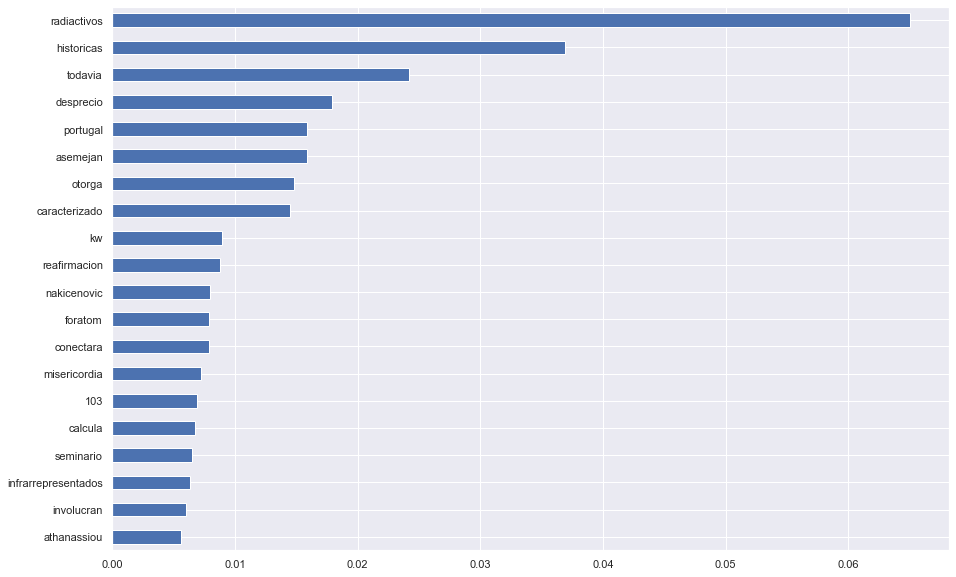

In [123]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [124]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 98.1


In [125]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

In [126]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

In [132]:
print("Precision Score : ",precision_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9822222222222222
Recall Score :  0.9822222222222222


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


## Segundo modelo

In [127]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [128]:
X_tfid = tfidf.fit_transform(X_train)

In [129]:
tf_idf_model = RandomForestClassifier(random_state=3)

In [130]:
tf_idf_model.fit(X_tfid, y_train)

RandomForestClassifier(random_state=3)

<AxesSubplot:>

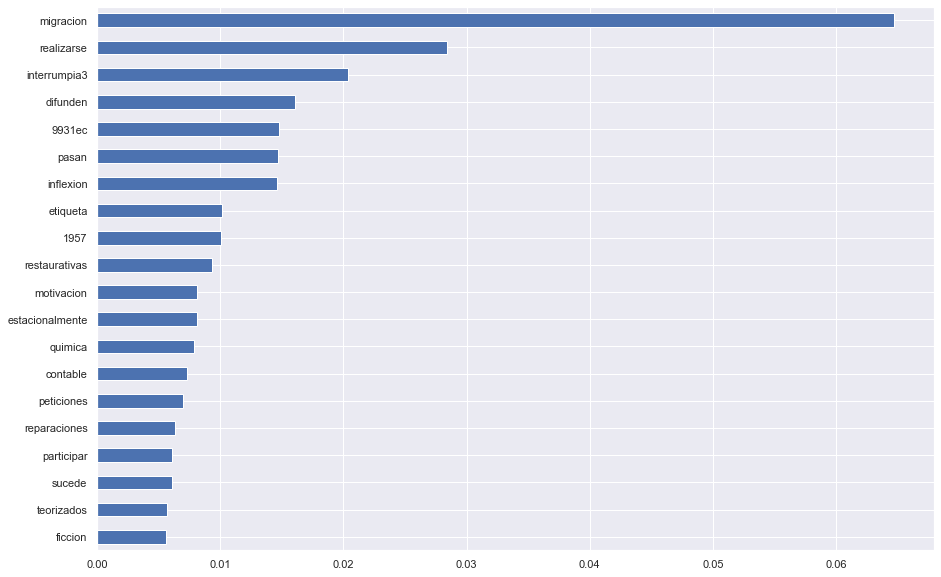

In [131]:
pd.Series(tf_idf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [135]:
y_train_tfidf_predict = tf_idf_model.predict(X_tfid)
y_test_tfidf_predict = tf_idf_model.predict(tfidf.transform(X_test))

In [136]:
print("Precision Score : ",precision_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9822222222222222
Recall Score :  0.9822222222222222


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
